In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
    
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [9]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

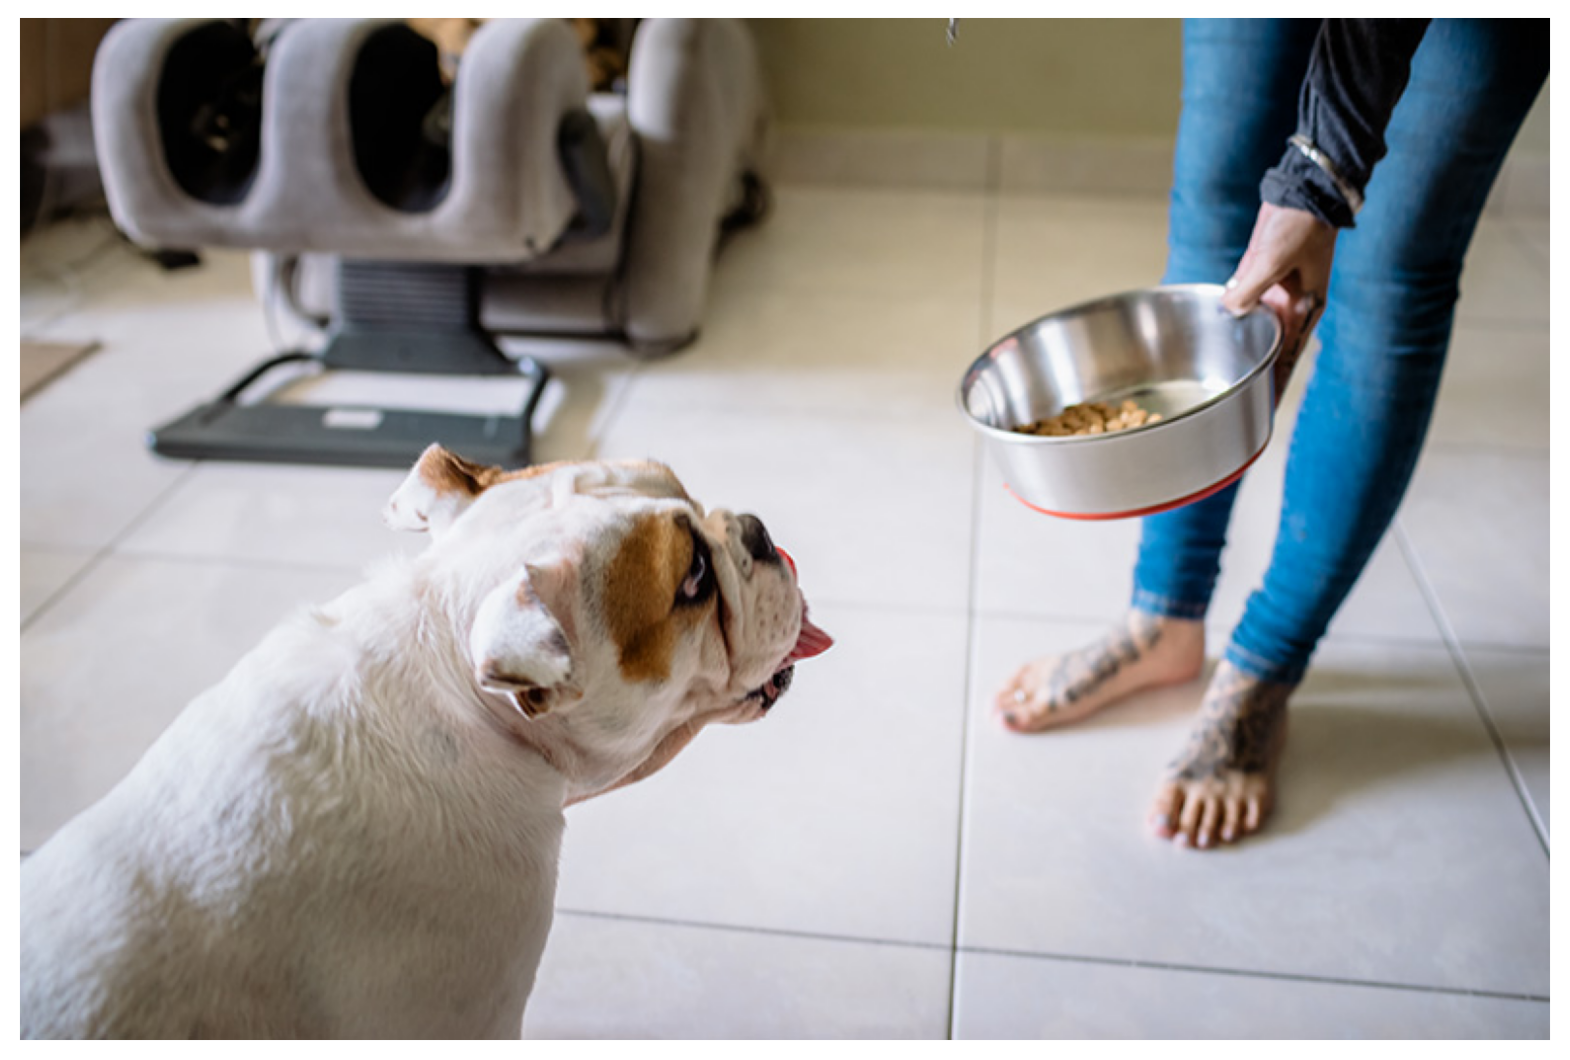

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [11]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/disi/miniconda3/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [12]:
masks = mask_generator.generate(image)

In [8]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


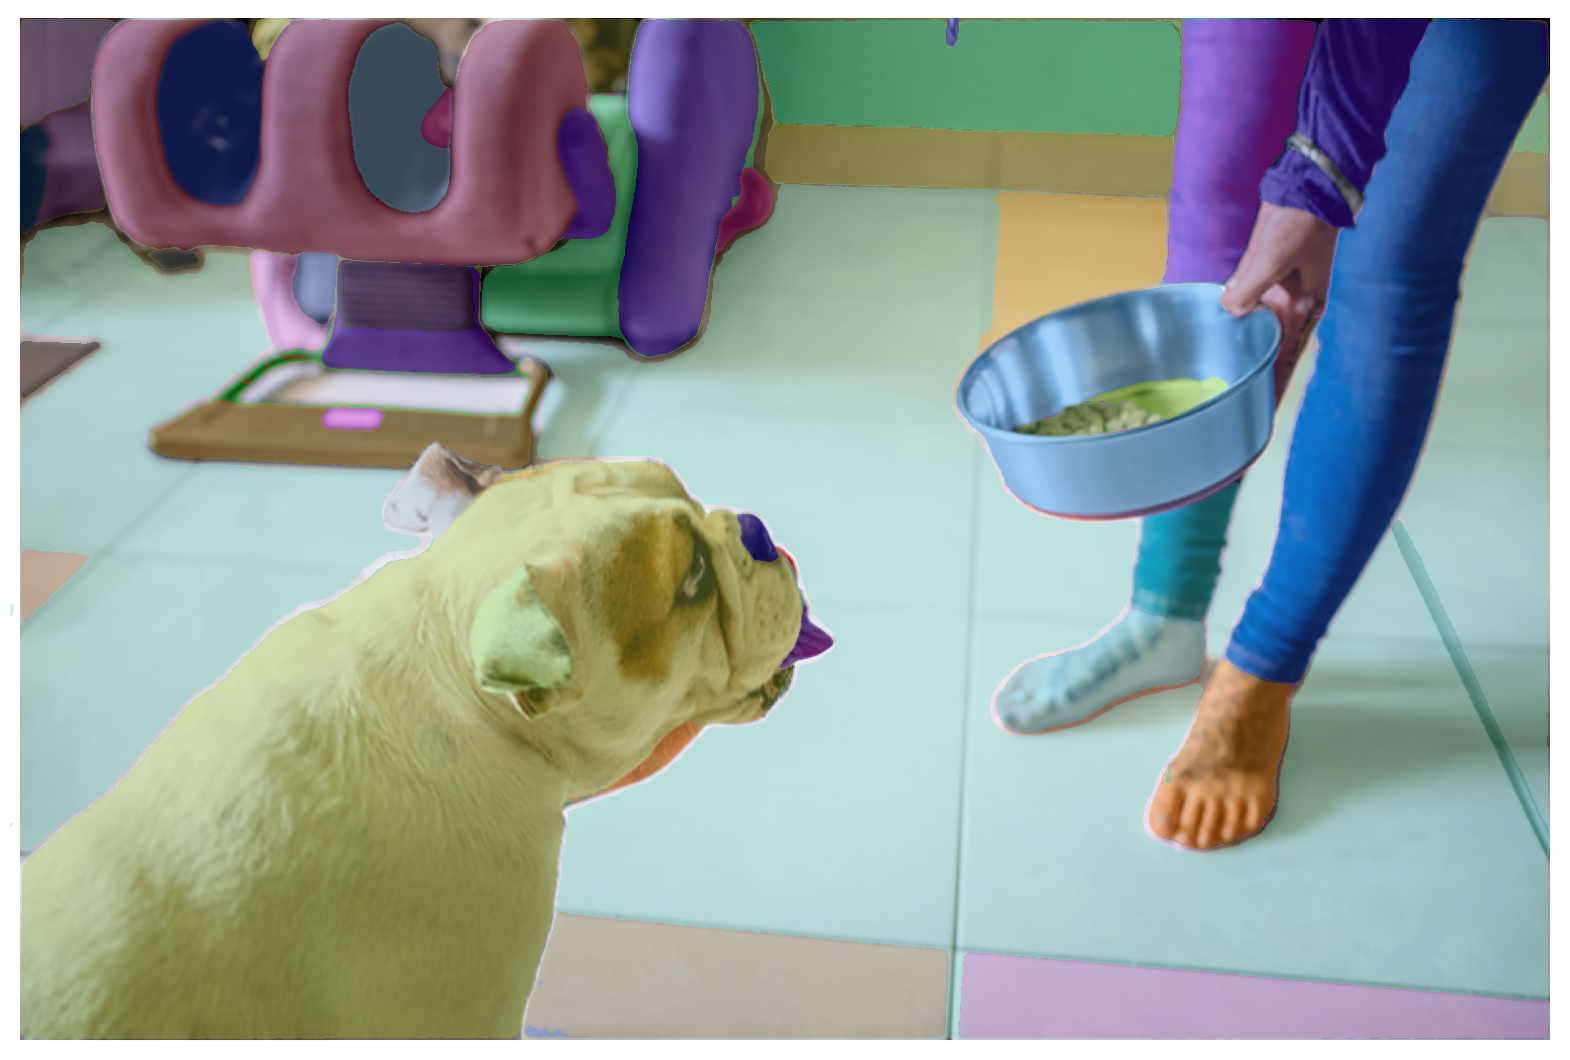

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [13]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=4,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=0,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [14]:
masks2 = mask_generator_2.generate(image)

In [12]:
len(masks2)

11

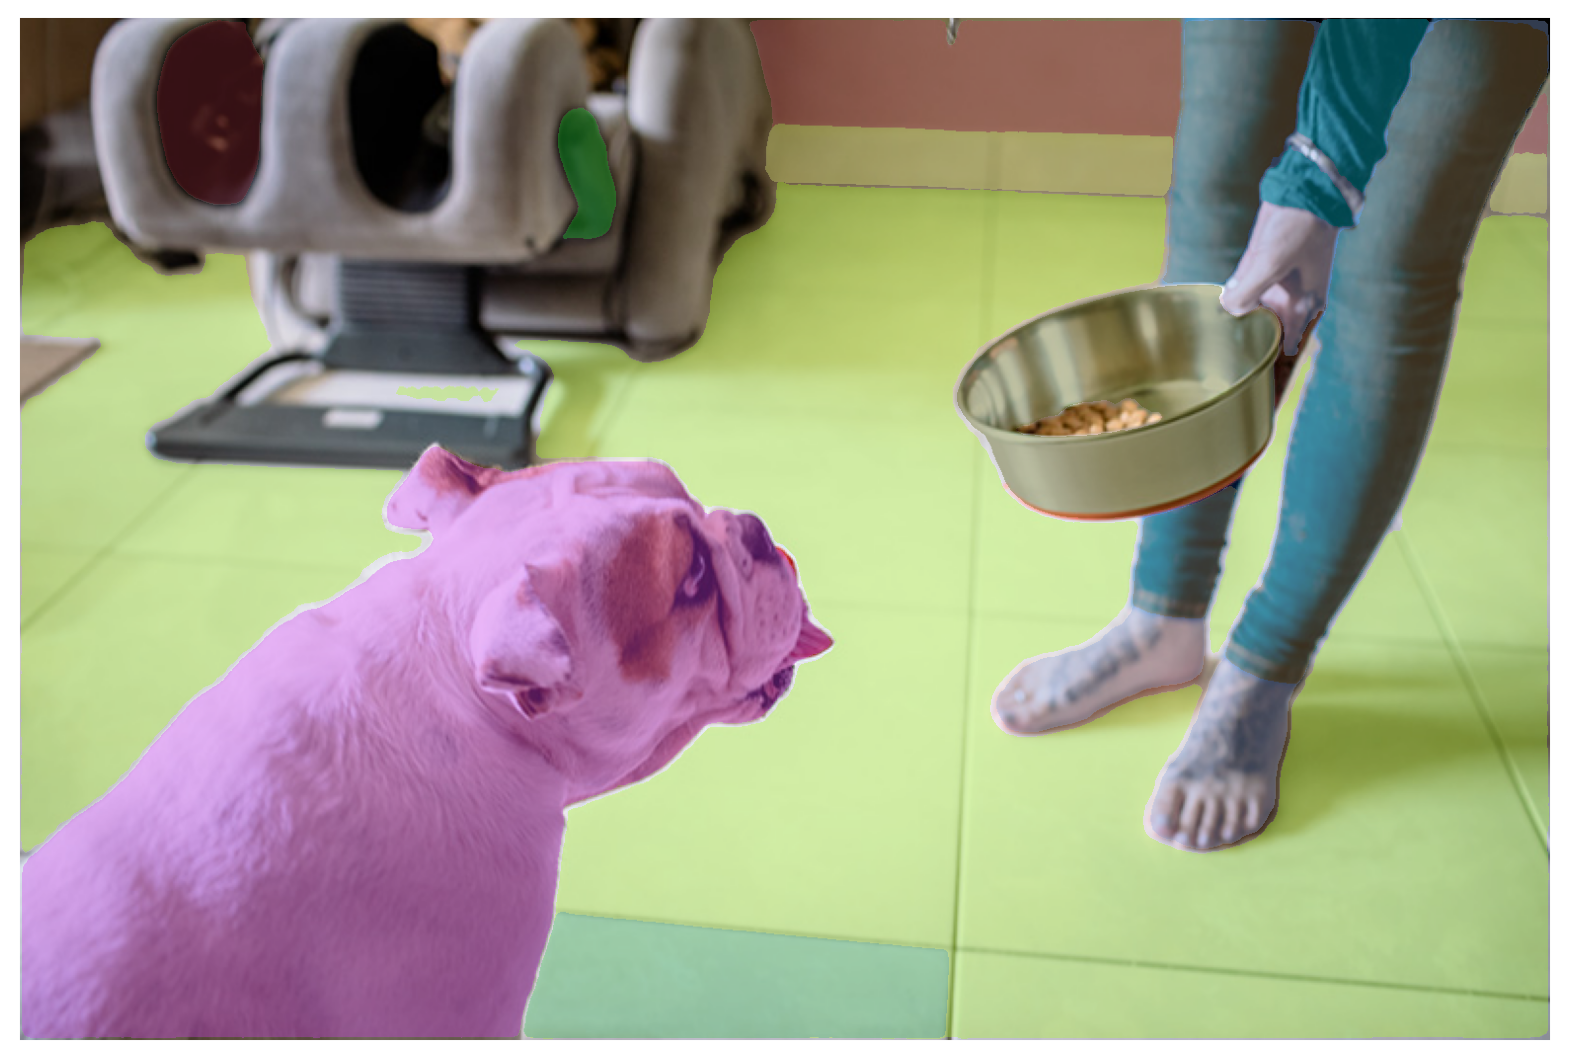

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

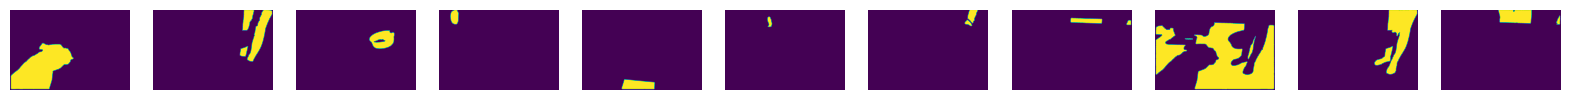

In [16]:
# Create a smaller subplot showing every mask in separate images
fig, axs = plt.subplots(1, len(masks2), figsize=(20,20))
for i, mask in enumerate(masks2):
    axs[i].imshow(mask['segmentation'])
    axs[i].axis('off')
plt.show()

In [15]:
masks[0]['bbox']


[12, 443, 816, 598]

In [17]:
def add_padding(bbox, image_shape, padding_p):
    """
    :param bbox: [x, y, w, h]
    :param image_shape: (height, width, channels)
    :param padding_p: padding percentage
    """
    x, y, w, h = bbox
    im_height, im_width, _ = image_shape
    padding = int(padding_p * max(w, h))

    y1 = max(0, y - padding)
    x1 = max(0, x - padding)
 
    new_height = im_height - y1 if h + 2 * padding > im_height else h + 2 * padding
    new_width = im_width - x1 if w + 2 * padding > im_width else w + 2 * padding
    
    if new_height == new_width:
        return x1, y1, new_height, new_width
    elif new_height > new_width:
        diff = new_height - new_width
        x1 = max(0, x1 - diff // 2)
        new_width = new_height
        return x1, y1, new_height, new_width
    else:
        diff = new_width - new_height
        y1 = max(0, y1 - diff // 2)
        new_height = new_width
        return x1, y1, new_height, new_width



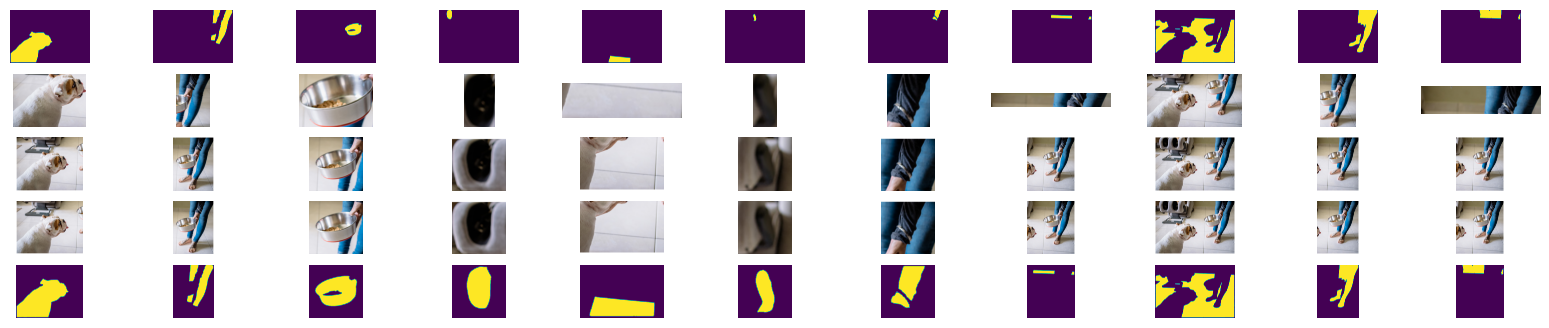

In [22]:
fig, axs = plt.subplots(5, len(masks2), figsize=(20,4))
for i, mask in enumerate(masks2):
    x, y, w, h = mask['bbox']
    axs[0, i].imshow(mask['segmentation'])
    axs[0, i].axis('off')
    axs[1, i].imshow(image[y:y+h, x:x+w])
    axs[1, i].axis('off')
    x1, y1, h1, w1 = add_padding((x, y, w, h), image.shape, 0.15)
    axs[2, i].imshow(image[y1:y1+h1, x1:x1+w1])
    axs[2, i].axis('off')
    
    axs[3, i].imshow(image[y1:y1+h1, x1:x1+w1])
    axs[3, i].axis('off')

    axs[4, i].imshow(mask['segmentation'][y1:y1+h1, x1:x1+w1])
    axs[4, i].axis('off')
plt.show()

## Next
Feed this to CLIP for classification given a set of classes.

# AlphaCLIP Testing


In [32]:
from torchvision import transforms

mask_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((224, 224)),
    transforms.Normalize(0.5, 0.26)
])
# alpha = mask_transform(binary_mask * 255)

In [ ]:
import alpha_clip
from PIL import Image

weights = 'checkpoints/clip_b16_grit1m_fultune_8xe.pth'
device = 'cuda'
model, preprocess = alpha_clip.load("ViT-B/16", weights, device=device)
# image_features = model.visual(image, alpha)

In [ ]:
# Pepare vocabulary with COCO
from datasets.dataset_vars import COCO_CATEGORIES
from typing import List

# Take vocabulary and mer with the default COCO vocabulary
def merge_vocabulary_COCO(vocabulary: List[str]) -> List[str]:
        default_voc = [c["name"] for c in COCO_CATEGORIES]
        return vocabulary + [c for c in default_voc if c not in vocabulary]


def take_vocabulary(vocabulary):

    vocabulary = list(set([v.lower().strip() for v in vocabulary]))
    # remove invalid vocabulary
    vocabulary = [v for v in vocabulary if v != ""]

    vocabulary = merge_vocabulary_COCO(vocabulary)

    return vocabulary

print(take_vocabulary(["dog"]))

In [97]:
x1, y1, h1, w1 = add_padding(masks[0]['bbox'], image.shape, 0.15)
cropped_img = image[y1:y1+h1, x1:x1+w1]

# image
binary_mask = masks[0]['segmentation'][y1:y1+h1, x1:x1+w1]
alpha = mask_transform((binary_mask * 255).astype(np.uint8))
alpha = alpha.half().cuda().unsqueeze(dim=0)

cropped_img = Image.fromarray(cropped_img)
cropped_img = preprocess(cropped_img).unsqueeze(0).half().to(device)
vocabulary = ['legs','jeans'] #add additional words here
vocabulary = take_vocabulary(vocabulary)
text = alpha_clip.tokenize(vocabulary).to(device)


with torch.no_grad():
    image_features = model.visual(cropped_img, alpha)
    text_features = model.encode_text(text)

# normalize
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

## print the result
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity.cpu().topk(5) # prints: [[9.388e-05 9.995e-01 2.415e-04]]

for value, index in zip(values[0], indices[0]):
    print(f"{vocabulary[index]}: {value.item()}")

dog: 0.658203125
hot dog: 0.11444091796875
cow: 0.0198822021484375
mud: 0.01064300537109375
towel: 0.00939178466796875


In [65]:
def prepare_batch(image, masks, mask_transform, preprocess, prompts):
    imgs = []
    alphas = []
    tokenized_prompts = alpha_clip.tokenize(prompts)

    for mask in masks:
        x, y, w, h = mask['bbox']
        binary_mask = mask['segmentation'][y:y+h, x:x+w]
        
        alpha = mask_transform((binary_mask * 255).astype(np.uint8))
        alpha = alpha.half().cuda()
        
        cropped_img = image[y:y+h, x:x+w]
        cropped_img = Image.fromarray(cropped_img)
        cropped_img = preprocess(cropped_img).half()

        imgs.append(cropped_img)
        alphas.append(alpha)

    batch = {
        'image': torch.stack(imgs),
        'alpha': torch.stack(alphas),
        'text': tokenized_prompts
    }
        
    return batch

66

In [89]:
def inference(batch, model, device='cuda'):
    cropped_img, alpha, tokenized_prompts = batch['image'], batch['alpha'], batch['text']
    
    cropped_img = cropped_img.to(device)
    alpha = alpha.to(device)
    text = tokenized_prompts.to(device)

    with torch.no_grad():
        image_features = model.visual(cropped_img, alpha)
        text_features = model.encode_text(text) 

    # normalize
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    return similarity

In [63]:
def prompts_from_vocab(vocabulary):
    return [f"a photo of a {v}" for v in vocabulary]

In [ ]:
prompts = prompts_from_vocab(vocabulary)
batch = prepare_batch(image, masks2, mask_transform, preprocess, prompts)
logits = inference(batch, model, device)

values, indices = logits.cpu().topk(5)

for dim in range(len(values)):
    print("\n\nTop 5 predictions for mask ", dim)
    for value, index in zip(values[dim], indices[dim]):
        print(f"\t{vocabulary[index]}: {value.item()}")

In [ ]:
predictions = logits.argmax(dim=-1)